# Results analysis

#### dataset Loading and options 

In [108]:
from datasets import (
    Dataset,
    load_dataset,
    concatenate_datasets,
    get_dataset_config_names,
)
import pandas as pd
import seaborn as sb
all_configs = get_dataset_config_names("CharlyR/varbench-evaluation")
print(all_configs)
all_datasets: list[Dataset] = []

for config in all_configs:
    conf_ds = load_dataset("CharlyR/varbench-evaluation", config, split="tikz")
    config_name_column = [config] * len(conf_ds)
    all_datasets.append(conf_ds.add_column("config", config_name_column))


dataset = concatenate_datasets(all_datasets)

import os

result_path = os.path.join("results", "all_results")
not os.path.exists("results/all_results") and os.mkdir(
    "results/" + "all_results"
)

['simpleLLM_benchmark_deepseekr1distillllama70b_pk_1_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_1.5', 'simpleLLM_benchmark_llama3.18binstant_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_5_t_0.7', 'simpleLLM_benchmark_llama370b8192_pk_1_t_0.7', 'simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7']


False

TODO: UPDATE:

**Are LLMs capable of generating variants of code?**
- RQ: Are LLM capable of generating valid variants ?
- RQ: How  often are the variants the exact reference solution ?
- RQ: Are they capable of modifying the right lines ?
- RQ: Are the performance correlated with the complexity of the edit?

## Variants Overall Validity

In [109]:
df  = dataset.to_pandas()[["config","id","parsing_score","compiling_score"]]

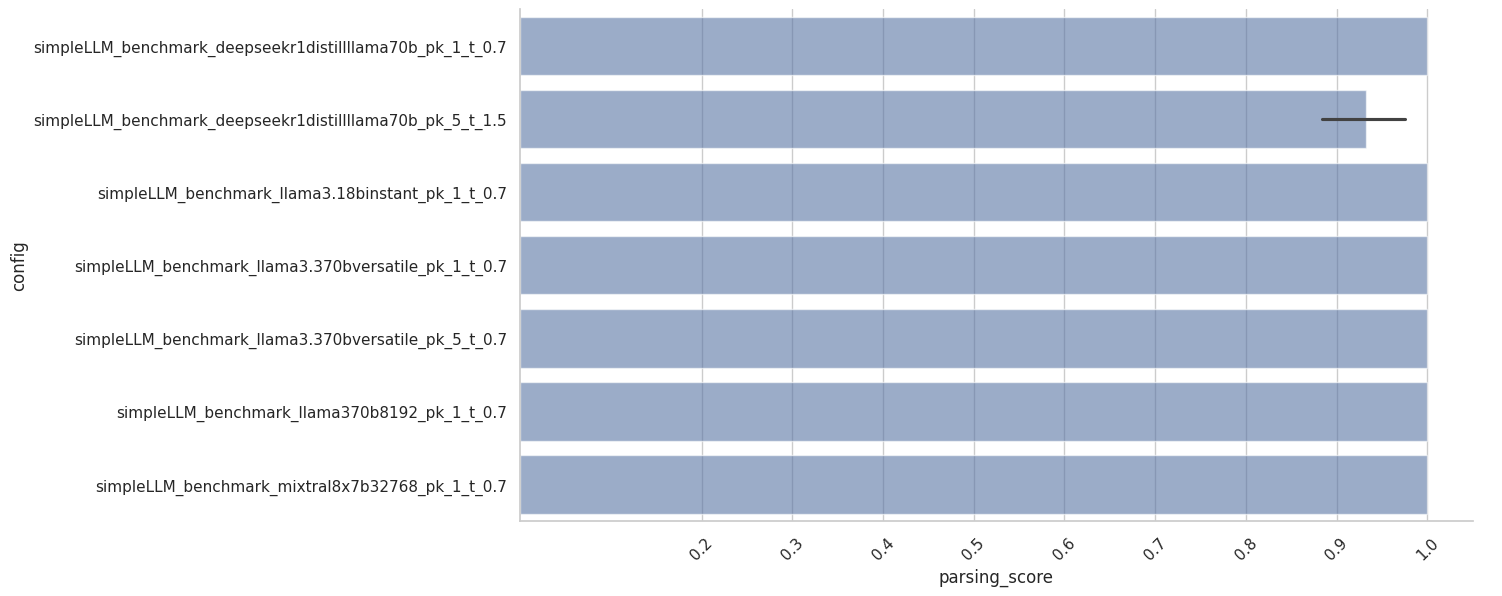

In [110]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="parsing_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["parsing_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

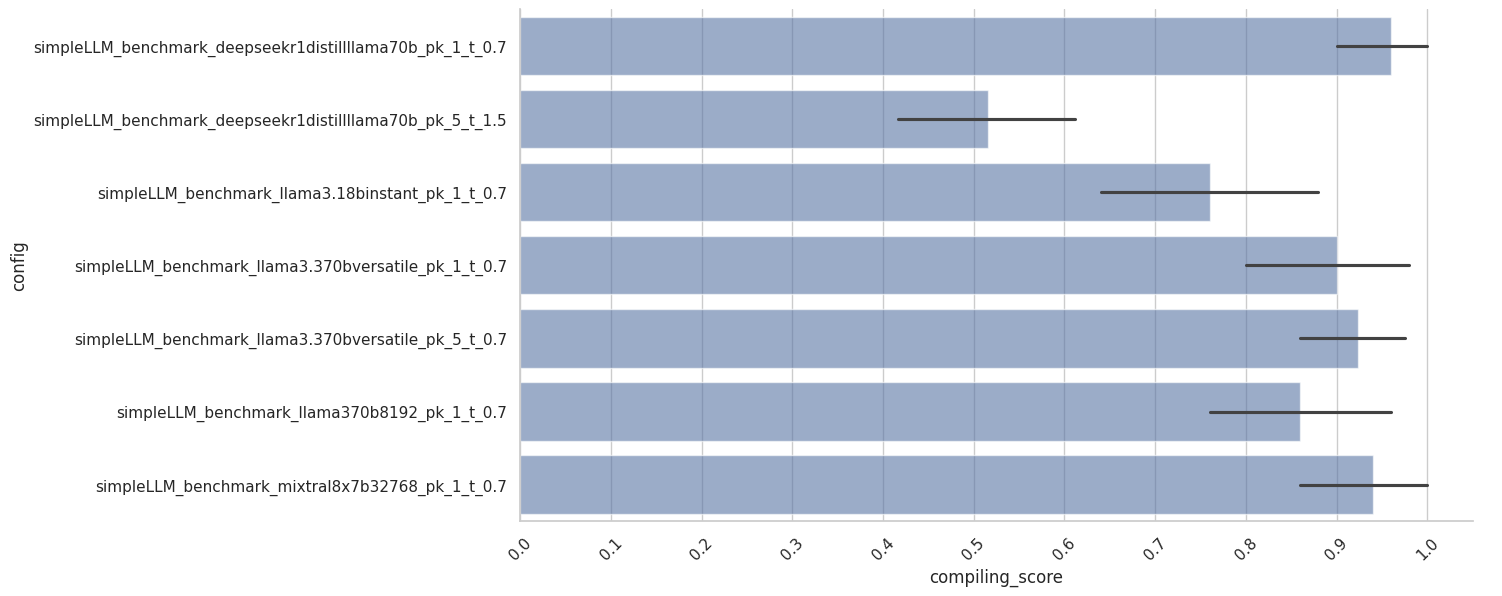

In [111]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="compiling_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["compiling_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

## Best prediction computation

---

In [112]:
from results_utils import MetricPolicy
import pandas as pd

computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric")
]

# TODO Update with metric_analysis output
most_important_metrics = ["PatchMetric", "LineMetric"]
metric_priority_order = most_important_metrics + (
    list(set(computed_metrics_names) - set(most_important_metrics))
)

print(computed_metrics_names + ["images_result", "predictions", "predictions_patches"])

result_df: pd.DataFrame = dataset.to_pandas().explode(
    computed_metrics_names + ["images_result", "predictions", "predictions_patches"]
)

df_sorted = result_df.sort_values(by=metric_priority_order, ascending=False)

# Get the highest row per group based on sorting order
result = df_sorted.groupby(["id", "config"]).first().reset_index()


result_df = result_df[computed_metrics_names + ["id", "config","difficulty"]].astype({m_name:'float' for m_name in computed_metrics_names})
result_df

['LPIPSMetric', 'TERPatchMetric', 'MSSSIMMetric', 'ChrfMetric', 'BleuMetric', 'PSNRMetric', 'ClipImageMetric', 'MSEMetric', 'ChrfPatchMetric', 'TERMetric', 'BleuPatchMetric', 'LineMetric', 'PatchMetric', 'ClipTextMetric', 'FeatureMatchMetric', 'CrystalBleuPatchMetric', 'CrystalBleuMetric', 'images_result', 'predictions', 'predictions_patches']


,LPIPSMetric,TERPatchMetric,MSSSIMMetric,ChrfMetric,BleuMetric,PSNRMetric,ClipImageMetric,MSEMetric,ChrfPatchMetric,TERMetric,BleuPatchMetric,LineMetric,PatchMetric,ClipTextMetric,FeatureMatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,id,config,difficulty
0,97.895119,51.079136,96.640633,98.826576,96.998154,44.214489,99.736710,99.803001,5.957026,97.832817,0.213829,0.0,0.0,23.523579,58.441559,0.222529,95.861595,donkey_higher_mane,simpleLLM_benchmark_deepseekr1distillllama70b_...,hard
1,94.017708,51.785713,88.620117,95.967018,88.396996,42.291893,97.421913,99.020058,26.908844,89.705879,4.481031,0.0,0.0,27.789425,72.972977,3.460161,87.258995,chimpanzee_squint_crosseyes,simpleLLM_benchmark_deepseekr1distillllama70b_...,medium
2,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.999985,100.000000,100.000000,100.000000,100.000000,100.0,100.0,27.442711,100.000000,100.000000,100.000000,bee_red_stripes,simpleLLM_benchmark_deepseekr1distillllama70b_...,easy
3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.999992,100.000000,100.000000,100.000000,100.000000,100.0,100.0,24.728065,100.000000,100.000000,100.000000,shark_no_teeth,simpleLLM_benchmark_deepseekr1distillllama70b_...,easy
4,93.984505,59.183674,94.136856,92.346718,88.040398,45.872265,99.455841,99.829895,38.496620,90.410957,7.212049,50.0,0.0,26.854486,72.580643,5.684877,86.406158,shark_other_set_pectoral_fin,simpleLLM_benchmark_deepseekr1distillllama70b_...,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,93.300240,53.846153,93.419952,98.993668,96.599609,41.918545,90.682388,99.178574,21.836052,97.757851,0.904941,0.0,0.0,25.129627,76.923080,1.035441,95.735550,cat_blue_nose,simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,easy
346,98.242912,52.777779,98.545006,98.689476,94.173805,51.498158,99.740501,99.966049,12.030615,95.547943,0.694018,0.0,0.0,25.525475,68.518517,0.825508,94.080742,shark_bigger_dorsal_fin,simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,medium
347,94.791824,50.000000,93.641815,95.996765,94.844803,46.224831,99.211304,99.587051,30.632431,93.609024,1.924592,100.0,0.0,24.090656,65.476189,1.737416,90.763580,bee_eyes,simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,hard
348,99.007896,50.000000,97.443756,97.824585,94.775833,45.449368,99.758133,99.805244,15.282422,90.256409,0.490835,0.0,0.0,24.997356,57.971016,0.464431,88.804710,chimpanzee_open_mouth,simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,easy


## Pre-Filtering

In [113]:
# ordering by text metrics IGNORED
""" text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf","Patch"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = [metric for metric in (text_metrics + other_metrics)]
print(text_metrics + other_metrics) """
#Ordering by priority metrics
filtered_df = result_df[metric_priority_order+ ["id", "config","difficulty"]]

In [114]:
filtered_df[filtered_df.isnull().any(axis=1)]

,PatchMetric,LineMetric,MSSSIMMetric,TERMetric,ClipTextMetric,BleuPatchMetric,CrystalBleuMetric,ChrfMetric,PSNRMetric,ChrfPatchMetric,FeatureMatchMetric,BleuMetric,ClipImageMetric,MSEMetric,LPIPSMetric,TERPatchMetric,CrystalBleuPatchMetric,id,config,difficulty
28,0.0,66.666664,NaN,87.804878,NaN,26.898645,85.162247,92.786057,NaN,62.968231,NaN,91.198792,NaN,NaN,NaN,50.000000,26.196075,cow_brown_white_dots,simpleLLM_benchmark_deepseekr1distillllama70b_...,hard
47,0.0,100.000000,NaN,87.062935,NaN,3.476955,87.919968,96.195602,NaN,43.581493,NaN,90.586449,NaN,NaN,NaN,50.000000,2.953135,bee_eyes,simpleLLM_benchmark_deepseekr1distillllama70b_...,hard
51,0.0,0.000000,NaN,83.944954,NaN,3.834791,76.779999,84.120422,NaN,34.742664,NaN,80.400642,NaN,NaN,NaN,50.000000,2.950456,chimpanzee_squint_crosseyes,simpleLLM_benchmark_deepseekr1distillllama70b_...,medium
51,0.0,0.000000,NaN,83.944954,NaN,3.834791,76.779999,84.120422,NaN,34.742664,NaN,80.400642,NaN,NaN,NaN,50.000000,2.950456,chimpanzee_squint_crosseyes,simpleLLM_benchmark_deepseekr1distillllama70b_...,medium
51,0.0,0.000000,NaN,50.000000,NaN,8.869287,50.325653,75.555603,NaN,35.261745,NaN,70.153221,NaN,NaN,NaN,50.000000,6.256627,chimpanzee_squint_crosseyes,simpleLLM_benchmark_deepseekr1distillllama70b_...,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.0,0.000000,NaN,90.151512,NaN,8.400635,86.724823,97.834892,NaN,28.235296,NaN,89.999969,NaN,NaN,NaN,54.471546,5.681467,squid_longer_tentacles,simpleLLM_benchmark_llama370b8192_pk_1_t_0.7,hard
297,0.0,0.000000,NaN,95.769234,NaN,5.431949,94.523972,97.216331,NaN,41.916721,NaN,96.374313,NaN,NaN,NaN,56.666668,3.847877,bee_eyes,simpleLLM_benchmark_llama370b8192_pk_1_t_0.7,hard
317,0.0,0.000000,NaN,70.909088,NaN,6.541035,85.632278,91.094711,NaN,37.629284,NaN,86.656204,NaN,NaN,NaN,50.000000,5.379416,duck_no_tail,simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,easy
331,0.0,0.000000,NaN,96.482414,NaN,0.061541,93.212158,97.893143,NaN,6.388003,NaN,94.996231,NaN,NaN,NaN,51.048950,0.072543,monkey_thiner,simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,medium


## Passing rate

In [115]:
def compute_pass(row):
    row["pass"] = not row.isnull().any()
    return row
pass_dataset = filtered_df[computed_metrics_names+["difficulty","id","config"]].apply(compute_pass,axis=1)


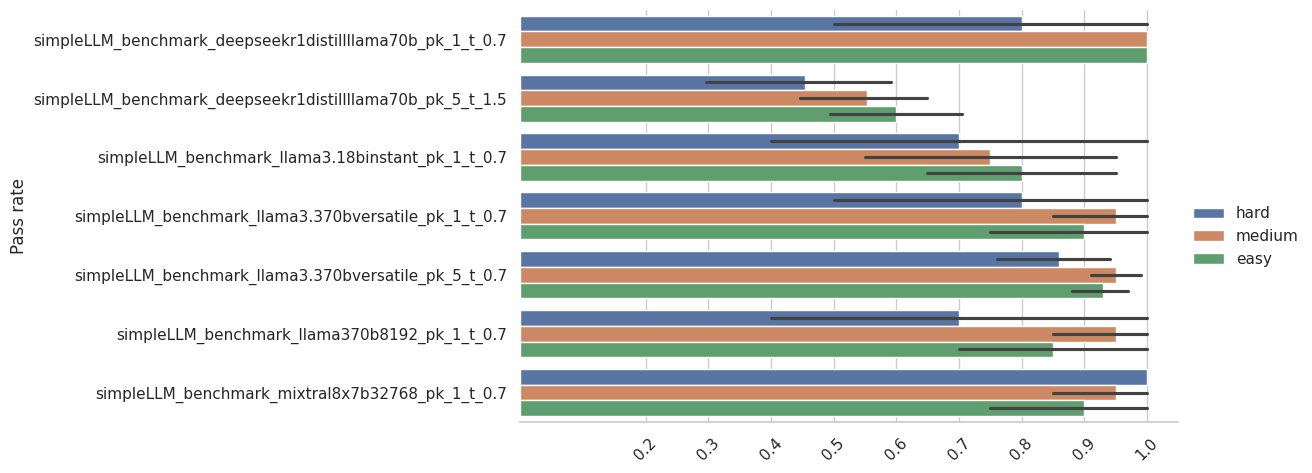

<Figure size 640x480 with 0 Axes>

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=pass_dataset, kind="bar",
    hue="difficulty", x="pass",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["parsing_score"].min(), 1.01, step=0.1))  # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Pass rate")
g.legend.set_title("")

plt.show()

plt.savefig(os.path.join(result_path,"pass_rate_difficulty.png"), dpi=300, bbox_inches="tight")


## Exact patch

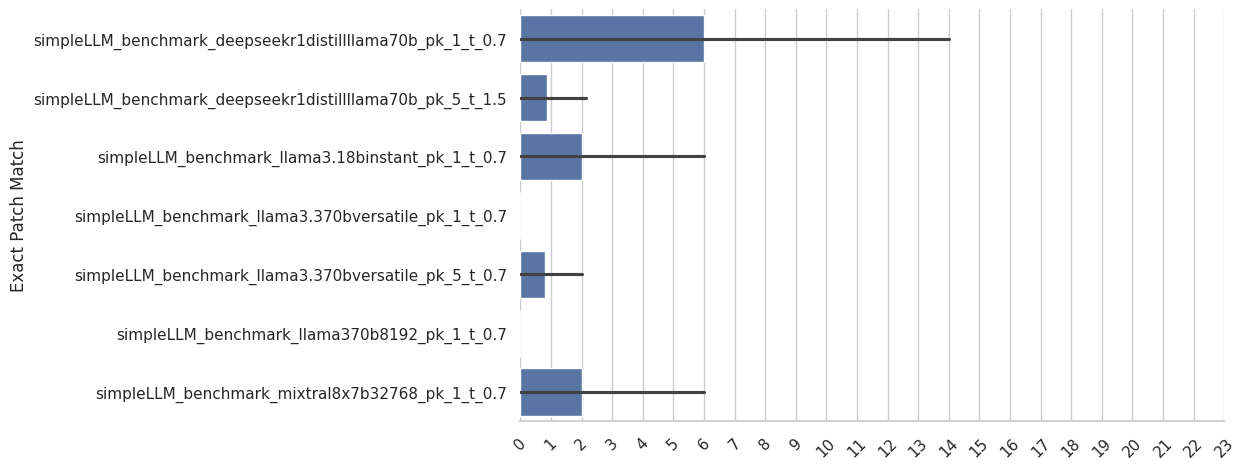

<Figure size 640x480 with 0 Axes>

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="PatchMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["PatchMetric"].mean()+filtered_df["PatchMetric"].std()*2, 1)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Exact Patch Match")
g.legend.set_title("")

plt.show()

plt.savefig(os.path.join(result_path,"same_patch_measures.png"), dpi=300, bbox_inches="tight")

## Right lines

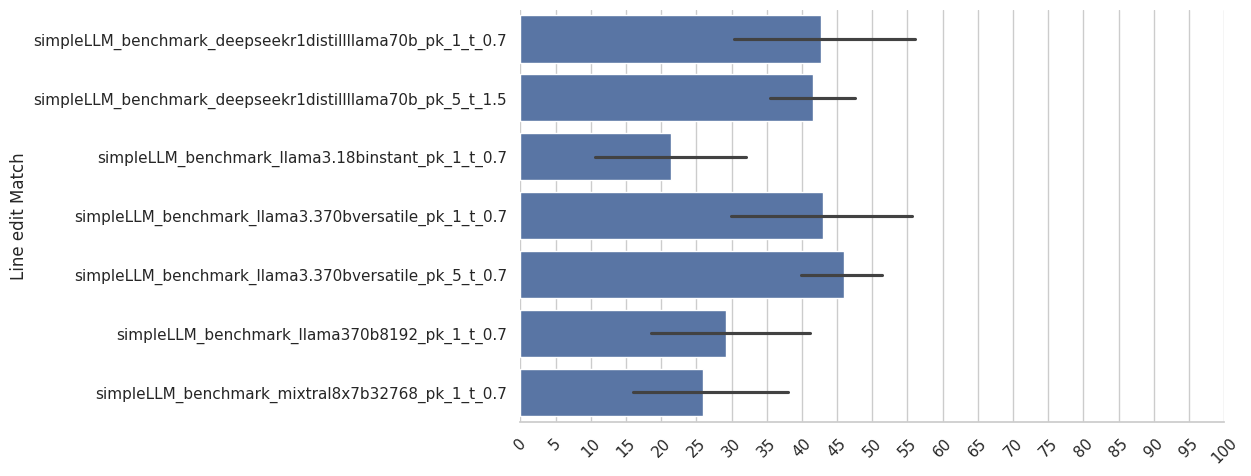

<Figure size 640x480 with 0 Axes>

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="LineMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["LineMetric"].max()+1, 5)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Line edit Match")
g.legend.set_title("")

plt.show()

plt.savefig(os.path.join(result_path,"same_patch_measures.png"), dpi=300, bbox_inches="tight")

## All metrics

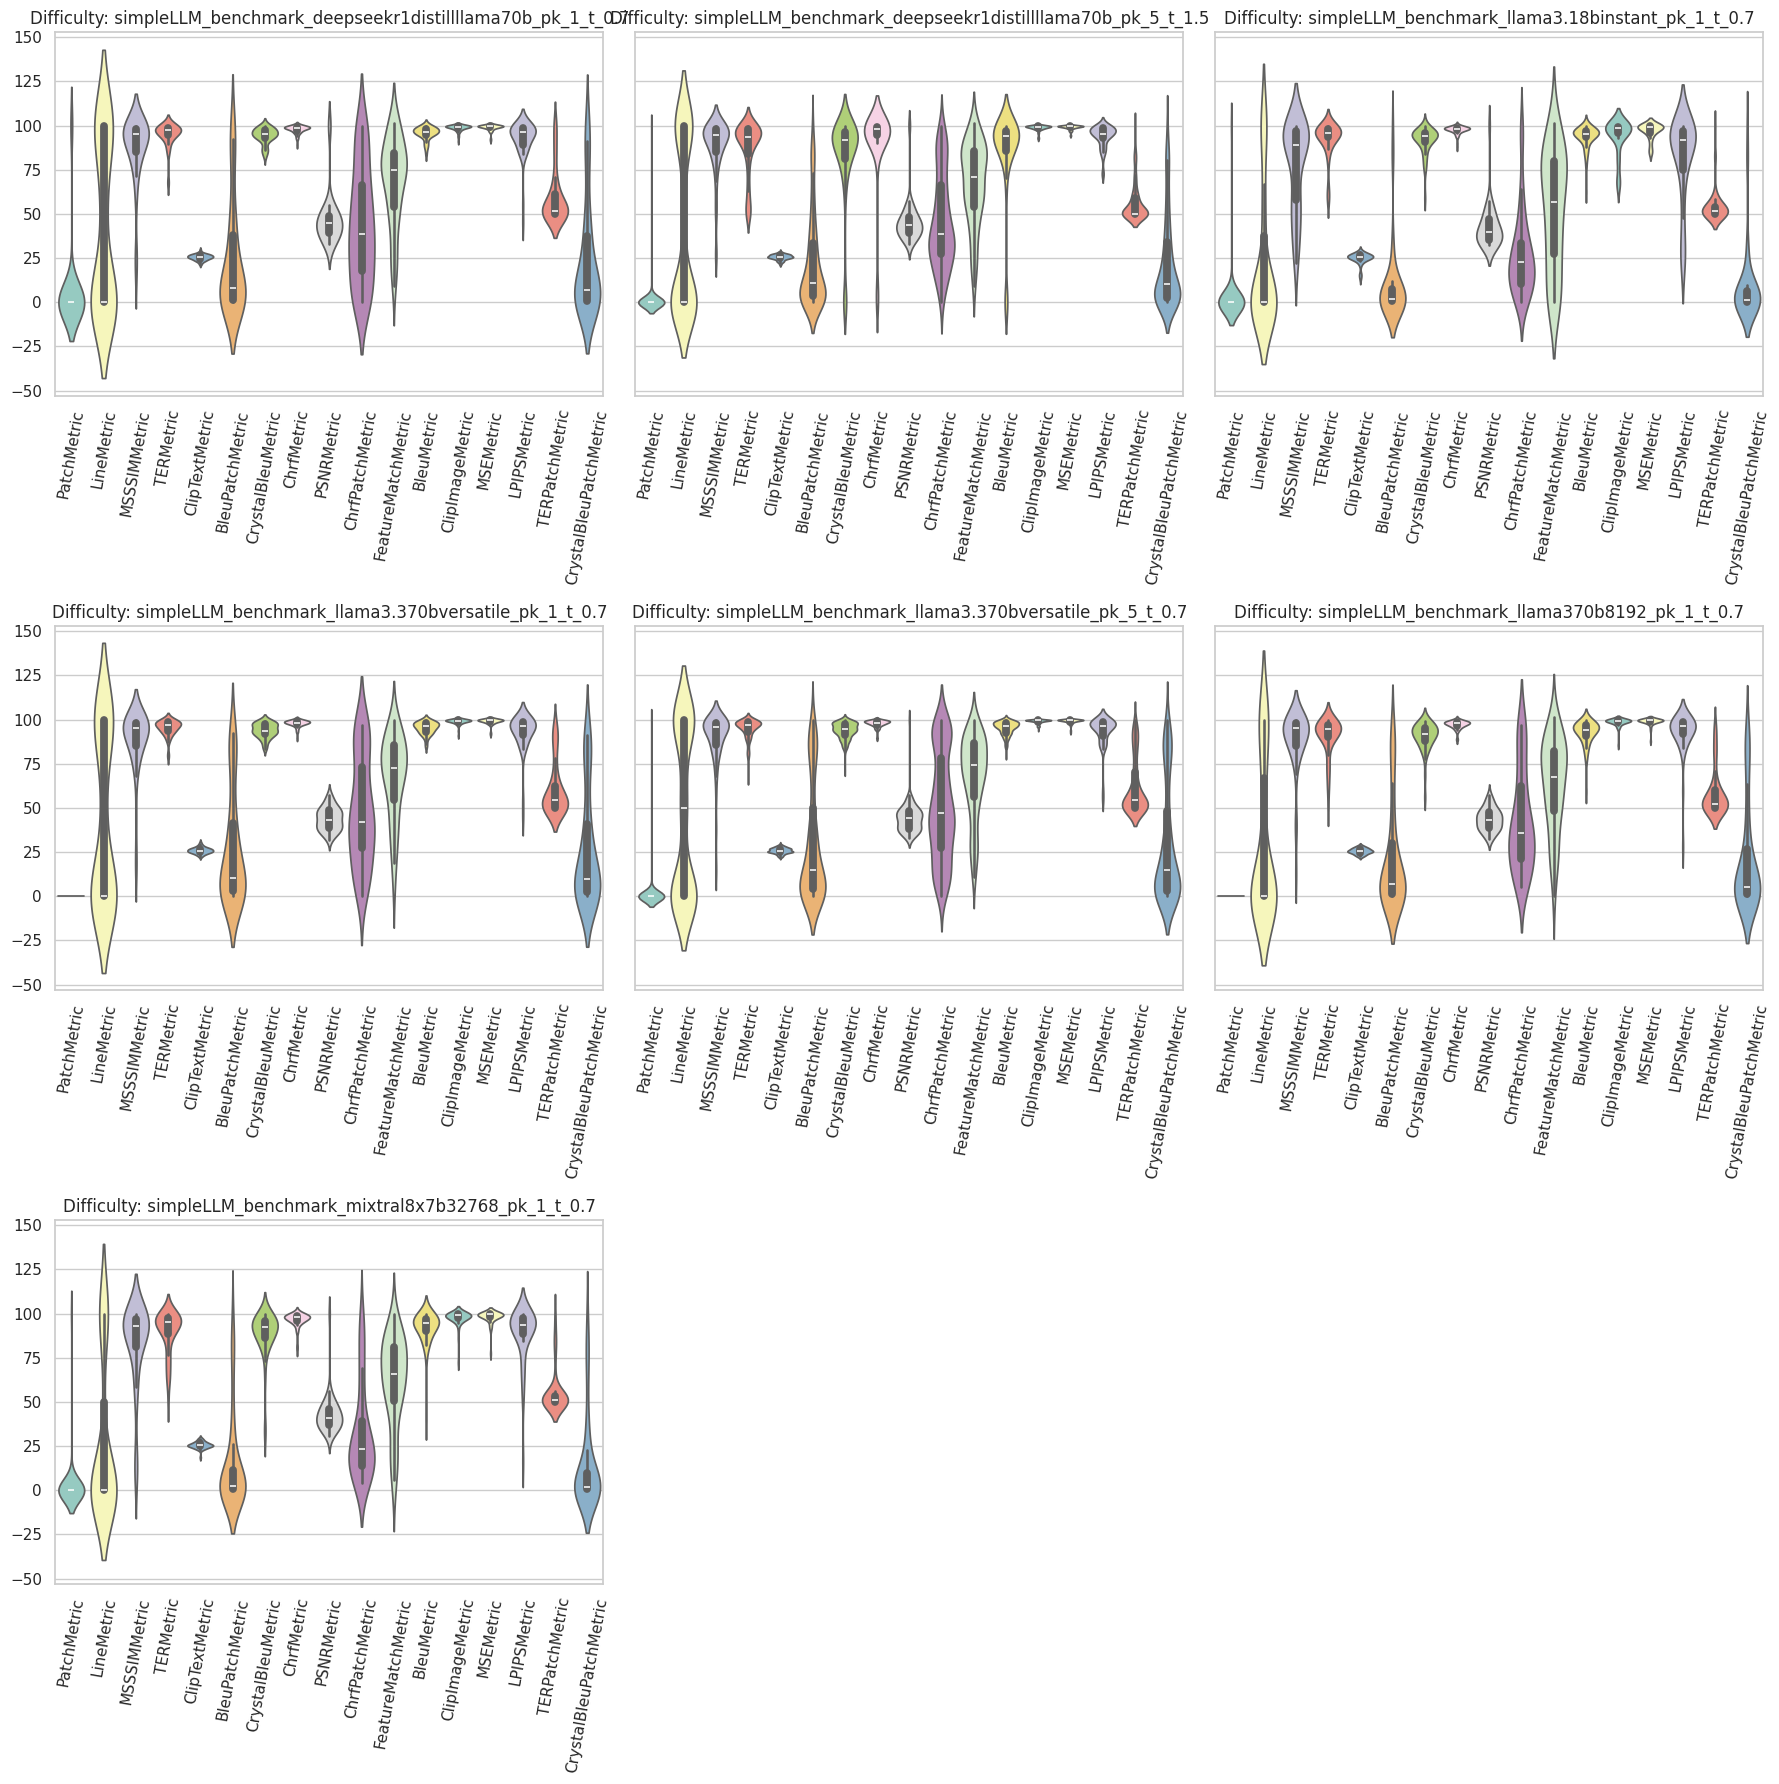

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_theme(style="whitegrid")

# Get unique configuration values
configs = filtered_df["config"].unique().tolist()

# Determine grid size
cols = 3
rows = (len(configs) // cols) + (len(configs) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, config_name in enumerate(configs):
    sns.violinplot(
        data=filtered_df[filtered_df['config'] == config_name], 
        ax=axes[i], 
        palette="Set3"
    )
    axes[i].set_title(f'Difficulty: {config_name}')
    axes[i].tick_params(axis='x', rotation=80)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(result_path, "violin_by_difficulty.png"), dpi=300, bbox_inches="tight")
plt.show()


In [126]:
filtered_df.dtypes

PatchMetric                float64
LineMetric                 float64
MSSSIMMetric               float64
TERMetric                  float64
ClipTextMetric             float64
BleuPatchMetric            float64
CrystalBleuMetric          float64
ChrfMetric                 float64
PSNRMetric                 float64
ChrfPatchMetric            float64
FeatureMatchMetric         float64
BleuMetric                 float64
ClipImageMetric            float64
MSEMetric                  float64
LPIPSMetric                float64
TERPatchMetric             float64
CrystalBleuPatchMetric     float64
id                          object
config                    category
difficulty                  object
dtype: object

In [127]:
filtered_df['config'] = pd.Categorical(filtered_df['config'], categories=configs, ordered=True)
averages = filtered_df.drop(["difficulty","id"],axis=1).groupby('config',observed=True).mean()
averages.to_csv(os.path.join(result_path,"avg_by_config.csv"))

averages

,PatchMetric,LineMetric,MSSSIMMetric,TERMetric,ClipTextMetric,BleuPatchMetric,CrystalBleuMetric,ChrfMetric,PSNRMetric,ChrfPatchMetric,FeatureMatchMetric,BleuMetric,ClipImageMetric,MSEMetric,LPIPSMetric,TERPatchMetric,CrystalBleuPatchMetric
config,,,,,,,,,,,,,,,,,
simpleLLM_benchmark_deepseekr1distillllama70b_pk_1_t_0.7,6.000000,42.666667,87.121044,94.862433,25.538132,24.598251,94.312417,97.882005,47.142326,43.714863,68.633202,95.744088,98.730110,98.988402,92.731428,59.338020,23.924547
simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_1.5,0.858369,41.630901,88.402563,86.989191,25.604527,22.376981,81.963193,88.651396,45.501691,46.191298,67.234068,84.486241,98.803980,99.071626,93.933592,56.381554,21.544876
simpleLLM_benchmark_llama3.18binstant_pk_1_t_0.7,2.000000,21.333333,77.368687,92.203078,24.801141,9.682423,91.668463,97.564960,42.548607,27.292151,53.080387,93.408525,93.803153,96.943648,81.430691,54.497398,9.264204
simpleLLM_benchmark_llama3.370bversatile_pk_1_t_0.7,0.000000,43.000000,87.866441,95.245254,25.968820,26.925900,93.878853,97.880692,43.887871,48.648256,67.364543,95.246501,98.899453,99.024600,92.800102,60.661830,26.186874
simpleLLM_benchmark_llama3.370bversatile_pk_5_t_0.7,0.800000,45.933333,88.956342,94.763280,25.874778,29.445244,93.822100,97.813735,44.071376,50.642563,67.648197,95.223867,99.049066,99.105941,93.341020,61.964980,28.620584
simpleLLM_benchmark_llama370b8192_pk_1_t_0.7,0.000000,29.166667,88.229801,90.310875,25.591525,21.029535,90.595815,97.170052,43.577550,42.574532,63.537677,92.544303,98.593353,98.931102,92.430594,58.331700,20.175873
simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,2.000000,26.000000,82.613254,89.564464,25.600338,15.120062,88.641137,96.528454,42.932941,32.235689,61.745902,91.121330,97.521580,98.129115,88.407121,55.635220,14.668909


In [129]:
filtered_df['config'] = pd.Categorical(filtered_df['config'], categories=configs, ordered=True)
averages = filtered_df.drop(["difficulty","id"],axis=1).groupby('config',observed=True).median()
averages.to_csv(os.path.join(result_path,"med_by_config.csv"))

averages

,PatchMetric,LineMetric,MSSSIMMetric,TERMetric,ClipTextMetric,BleuPatchMetric,CrystalBleuMetric,ChrfMetric,PSNRMetric,ChrfPatchMetric,FeatureMatchMetric,BleuMetric,ClipImageMetric,MSEMetric,LPIPSMetric,TERPatchMetric,CrystalBleuPatchMetric
config,,,,,,,,,,,,,,,,,
simpleLLM_benchmark_deepseekr1distillllama70b_pk_1_t_0.7,0.0,0.0,95.268536,97.235386,25.591466,8.285279,95.218842,98.688534,44.990246,38.801376,74.973160,96.625275,99.456112,99.675064,96.610401,51.892857,6.716932
simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_1.5,0.0,0.0,94.866653,93.658539,25.763992,11.028661,91.799500,97.872650,43.480221,38.808575,71.084335,94.229721,99.430023,99.540771,95.526749,50.000000,10.176217
simpleLLM_benchmark_llama3.18binstant_pk_1_t_0.7,0.0,0.0,88.924805,95.777653,25.715508,1.617397,94.372723,98.306614,39.681490,22.616692,56.618366,95.191605,98.436115,99.326729,91.831501,51.388889,1.266220
simpleLLM_benchmark_llama3.370bversatile_pk_1_t_0.7,0.0,0.0,95.517990,96.819698,25.891090,10.220786,93.830627,98.306469,43.175064,42.213858,72.368423,96.148502,99.464615,99.671272,96.540611,54.517664,9.769201
simpleLLM_benchmark_llama3.370bversatile_pk_5_t_0.7,0.0,50.0,95.974854,96.932518,25.654907,15.087583,94.600487,98.357716,44.214489,46.973225,74.074074,96.307503,99.502113,99.707520,96.615250,54.545456,14.988953
simpleLLM_benchmark_llama370b8192_pk_1_t_0.7,0.0,0.0,95.045212,94.448395,25.421940,6.692929,92.094791,97.834713,43.434155,35.875208,67.346939,94.279785,99.320236,99.678169,96.344452,52.452154,5.163807
simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7,0.0,0.0,92.998886,95.278622,25.499083,2.154282,92.649632,97.843437,41.087635,23.141344,65.573769,94.713856,98.965286,99.553345,93.479645,50.881618,1.824162
